## 4.2 Exercise: Predicting Fuel Efficiency

First I will import needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
from IPython.display import display
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn import preprocessing
import sklearn.metrics as metrics

## Step 1: Load the data as a Pandas data frame and ensure that it imported correctly.

In [13]:
# I will use pandas to pull the data to create a data frame to work from
Car_mpg = pd.read_csv("auto-mpg.csv")
Car_mpg

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


## Step 2: Begin by prepping the data for modeling:

* Remove the car name column.
* The horsepower column values likely imported as a string data type. Figure out why and replace any strings with the column mean.
* Create dummy variables for the origin column.

In [14]:
# I will use drop to remove the Car name coulumn 
Car_mpg = Car_mpg.drop('car name',axis=1)

In [15]:
# Next I will use info to find out if it is a int64, float64, or an object
Car_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 25.0+ KB


In [16]:
# As seen above we see that the horsepower variable is a object 
# data type. So I will use unique to see what the variables are.
Car_mpg.horsepower.unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [17]:
# Above we can see that the odd value is '?' that is representing null.
# Next I will use str.replace to change the '?' to 'NaN' then replace the NaN with the mean
Car_mpg.horsepower = Car_mpg.horsepower.str.replace('?','NaN').astype(float)
Car_mpg.horsepower.fillna(Car_mpg.horsepower.mean(),inplace=True)

<ipython-input-17-8f52c08f5ea3>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  Car_mpg.horsepower = Car_mpg.horsepower.str.replace('?','NaN').astype(float)


In [18]:
# Next I will use astype to turn the horsepower into an int and the use info 
# to check the updated variable.
Car_mpg.horsepower = Car_mpg.horsepower.astype(int)
Car_mpg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    int64  
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 25.0 KB


In [19]:
# The Origin column is supposed  categorical so we can use dataset.pop to 
# change them to seperate columns
origin = Car_mpg.pop('origin')
Car_mpg['origin_1'] = (origin == 1)*1.0
Car_mpg['origin_2'] = (origin == 2)*1.0
Car_mpg['origin_3'] = (origin == 3)*1.0
Car_mpg.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_1,origin_2,origin_3
393,27.0,4,140.0,86,2790,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52,2130,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84,2295,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79,2625,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82,2720,19.4,82,1.0,0.0,0.0


## Step 3: Create a correlation coefficient matrix and/or visualization. Are there features highly correlated with mpg?

In [20]:
# I will use describe to see the summary statistics of the data set
display(Car_mpg.describe())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_1,origin_2,origin_3
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.462312,2970.424623,15.568090,76.010050,0.625628,0.175879,0.198492
std,7.815984,1.701004,104.269838,38.199230,846.841774,2.757689,3.697627,0.484569,0.381197,0.399367
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.500000,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,0.000000,0.000000,0.000000
50%,23.000000,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [21]:
# I will now use corr to see the correlation between the variables 
Car_mpg.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_1,origin_2,origin_3
mpg,1.000000,-0.775396,-0.804203,-0.771543,-0.831741,0.420289,0.579267,-0.568192,0.259022,0.442174
cylinders,-0.775396,1.000000,0.950721,0.839061,0.896017,-0.505419,-0.348746,0.604351,-0.352861,-0.396479
displacement,-0.804203,0.950721,1.000000,0.893760,0.932824,-0.543684,-0.370164,0.651407,-0.373886,-0.433505
horsepower,-0.771543,0.839061,0.893760,1.000000,0.860676,-0.684376,-0.411750,0.486067,-0.281334,-0.321232
weight,-0.831741,0.896017,0.932824,0.860676,1.000000,-0.417457,-0.306564,0.598398,-0.298843,-0.440817
acceleration,0.420289,-0.505419,-0.543684,-0.684376,-0.417457,1.000000,0.288137,-0.250806,0.204473,0.109144
model year,0.579267,-0.348746,-0.370164,-0.411750,-0.306564,0.288137,1.000000,-0.139883,-0.024489,0.193101
origin_1,-0.568192,0.604351,0.651407,0.486067,0.598398,-0.250806,-0.139883,1.000000,-0.597198,-0.643317
origin_2,0.259022,-0.352861,-0.373886,-0.281334,-0.298843,0.204473,-0.024489,-0.597198,1.000000,-0.229895
origin_3,0.442174,-0.396479,-0.433505,-0.321232,-0.440817,0.109144,0.193101,-0.643317,-0.229895,1.000000


As seen above we see that the relationship between “mpg” and “weight” is -0.8. which means as the weight goes up the the mpg goes down.

<AxesSubplot:>

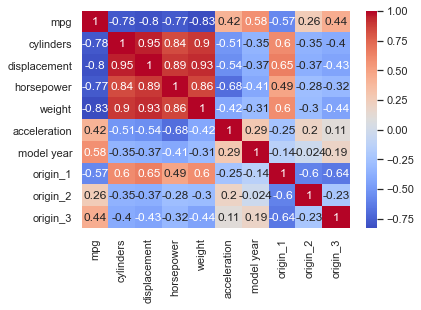

In [22]:
# Next I will use seaborn to create a heatmap
sns.heatmap(Car_mpg.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

As seen above we see the highest positive correlation mpg has is with model year which is at 0.58. While the highest negative correlation is -0.83 with weight.

## Step 4: Plot mpg versus weight. Analyze this graph and explain how it relates to the corresponding correlation coefficient.

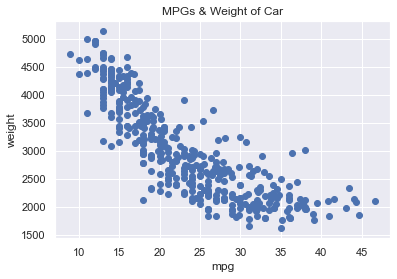

In [23]:
# create a scatter plot for mpg vs. weight
xData = Car_mpg.mpg
yData = Car_mpg.weight
# Create titles for the plot and the variables
plt.scatter(xData, yData)
plt.title('MPGs & Weight of Car')
plt.xlabel('mpg')
plt.ylabel('weight')
plt.show()

As seen above the graph relates to the corresponding correlation coefficientas as the weight increases the mpgs go down. While the weight goes down the mpgs goes down

## Step 5: Randomly split the data into 80% training data and 20% test data, where your target is mpg.

In [28]:
# The X data will drop the mpg variable 
Xdata = Car_mpg.drop('mpg',axis=1)
# The Y data will be just the mpg variable 
Ydata = Car_mpg.mpg   
# Next I will use preprocessing.scale to scale Xdata variables
scale = preprocessing.scale(Xdata)
# Next I will turn my scale into a dataframe 
Xscale = pd.DataFrame(scale,columns=Xdata.columns)
# Next I will split the data into 80% training data and 20% test data
X_train,X_test,y_train,y_test = train_test_split(Xscale,Ydata,test_size=.2,random_state=0) 

## Step 6: Train an ordinary linear regression on the training data.

In [29]:
# Next I will set my model to the LinearRegression model
model = LinearRegression()
# train the model on both x and y training data
model.fit(X_train,y_train)

LinearRegression()

In [32]:
# Next I will interpret the coefficient by printing the y-intercept, beta coefficient
# Then use zip for the mpgs and the coefficients
print(model.intercept_)
print(model.coef_)
zip(Ydata, model.coef_)

23.396532211268266
[-0.68366073  2.62153882 -0.79793001 -5.63776469  0.52610198  2.82673429
 -0.79259726  0.3852403   0.59398026]


In [34]:
# Next I will make a prediction for to see how accurately the algorithm predicts 
# the percentage score
y_pred = model.predict(X_test)

In [35]:
# last I will compare the actual and predicted 
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
65,14.0,12.954342
132,25.0,23.757310
74,13.0,11.465930
78,21.0,21.686198
37,18.0,17.190056
...,...,...
269,30.9,27.540158
235,26.0,30.173703
145,32.0,29.717026
196,24.5,28.038465


## Step 7: Calculate R2, RMSE, and MAE on both the training and test sets and interpret your results.

In [36]:
# Next I will calculate the R2, RMSE, and MAE and MSE because that is needed 
# to calculate the rmseon both the training and test sets
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(y_test,y_pred)

print("Results of sklearn.metrics for the actual output values for the y_test for the model:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics for the actual output values for the y_test for the model:
MAE: 2.7001459023714567
MSE: 10.990735230745411
RMSE: 3.315227779617173
R-Squared: 0.8268012940852751


* MAE also known as the Mean Absolute Error coming in with an average error at 350.00 
* RMSE also known as the root mean squared error is at 3.32 which is the square root which is similar to the MSE also known as the mean squared error
* R-Squared is 0.83 

## Step 8: Pick another regression model and repeat the previous two steps. Note: Do NOT choose logistic regression as it is more like a classification model.

## Step 9: Train a regression on the training data

In [59]:
# Import statsmodels to build another model to create a comparison
from sklearn.preprocessing import StandardScaler

In [65]:
# First I will use regularization to reduce my variance by standardizing my features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(Car_mpg)
mpgs = Car_mpg.mpg

In [84]:
# Next I will use lasso to create a Lasso regression
regression = Lasso(alpha=0.5)

In [85]:
# Next I will use regression and fit to create my model of my regression
model = regression.fit(features_standardized, mpgs)

In [86]:
# Next I will use coef_ to view the coefficients
model.coef_

array([ 7.30615906, -0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ])

In [88]:
model.fit(X_train,y_train)

Lasso(alpha=0.5)

In [89]:
# Next I will interpret the coefficient by printing the y-intercept, beta coefficient
# Then use zip for the mpgs and the coefficients
print(model.intercept_)
print(model.coef_)
zip(Ydata, model.coef_)

23.418839612788748
[-0.         -0.         -0.61583011 -4.23781321  0.          2.39141433
 -0.75543869  0.          0.        ]


In [91]:
# Next I will make a prediction for to see how accurately the algorithm predicts 
# the percentage score
pred = model.predict(X_test)

In [93]:
# last I will compare the actual and predicted 
df = pd.DataFrame({'Actual': y_test, 'Predicted': pred})
df

,Actual,Predicted
65,14.0,13.649135
132,25.0,24.155061
74,13.0,13.032237
78,21.0,22.037585
37,18.0,18.070971
...,...,...
269,30.9,28.308583
235,26.0,29.046608
145,32.0,28.642688
196,24.5,27.586293


## Step 10: Calculate R2, RMSE, and MAE on both the training and test sets and interpret your results.

In [94]:
# Next I will calculate the R2, RMSE, and MAE and MSE because that is needed 
# to calculate the rmseon both the training and test sets
mae = metrics.mean_absolute_error(y_test, pred)
mse = metrics.mean_squared_error(y_test, pred)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(y_test,pred)

print("Results of sklearn.metrics for the actual output values for the y_test for the model:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics for the actual output values for the y_test for the model:
MAE: 2.5432424319927436
MSE: 10.905789840711147
RMSE: 3.302391533527051
R-Squared: 0.8281399153256631


* MAE also known as the Mean Absolute Error coming in with an average error at 2.54 which is lower than the first prediction 
* RMSE also known as the root mean squared error is at 3.30 which is the square root which is similar to the last regression
* R-Squared is 0.83 which is pretty much the same.